# ANÁLISIS EDA
## Descripción del Proyecto
El objetivo de este trabajo es la detección de anomalías en escáneres de rayos X de equipajes mediante el uso de aprendizaje profundo.

El modelo desarrollado está entrenado para identificar y localizar 5 clases de objetos potencialmente peligrosos dentro del equipaje:

- Pistola (firearm)
- Cuchillo (knife)
- Alicates (pliers)
- Tijeras (scissors)
- Llave inglesa (wrench)

Esta implementación busca facilitar y automatizar la vigilancia inteligente en los sistemas de seguridad de los aeropuertos, mejorando la precisión y eficiencia de los operadores.

## Dataset: X-Ray Baggage Scanner Anomaly Detection
- Origen: Kaggle Dataset Link
- Descripción: El dataset consiste en imágenes de rayos X de equipajes con sus correspondientes anotaciones (bounding boxes) para las 5 clases de objetos mencionadas. El análisis exploratorio (EDA) reveló que se trata de un dataset con objetos generalmente pequeños, centrados en la imagen y con un desbalanceo moderado en la clase pliers.# Detección y Localización de Anomalías en Escáneres de Rayos X de Equipajes

## I. Descripción del Problema
El desafío central de este proyecto es la **detección y localización de anomalías** en imágenes generadas por escáneres de rayos X de equipajes. La tarea se enfoca en la **vigilancia inteligente automatizada** en entornos de seguridad, como aeropuertos, buscando mejorar la precisión y la eficiencia de los procesos de inspección actualmente manuales.

## II. Objetivo del Proyecto
El objetivo principal es desarrollar un **modelo de Detección de Objetos** basado en **Aprendizaje Profundo** (*Deep Learning*) que sea capaz de:

1.  **Identificar** (Clasificación).
2.  **Localizar** (*Bounding Box Regression*).

Cinco (5) clases específicas de **objetos potencialmente peligrosos** ocultos dentro de los equipajes:

* **Pistola** (*firearm*)
* **Cuchillo** (*knife*)
* **Alicates** (*pliers*)
* **Tijeras** (*scissors*)
* **Llave inglesa** (*wrench*)

## III. Características del Dataset (*X-Ray Baggage Scanner Anomaly Detection*)
La dificultad del problema se ve influenciada directamente por las propiedades del conjunto de datos, el cual consiste en imágenes de rayos X con anotaciones de cajas delimitadoras (*bounding boxes*). El Análisis Exploratorio de Datos (EDA) revela los siguientes desafíos y características a considerar para el modelado:

| Característica | Detalle | Fuente en el Data Set |
| :--- | :--- | :--- |
| **Baja Densidad de Objetos** | En promedio, las imágenes contienen **solo 1.00 objeto** por imagen, lo que simplifica la tarea al no requerir el manejo de múltiples detecciones por muestra. | `Avg de objetos por imagen: 1.00` |
| **Tamaño de los Objetos** | Los objetos son generalmente **pequeños**. El área normalizada promedio de las *bounding boxes* es de **0.0107** (sobre un área de 1.0). | `Area - Mean: 0.0107` |
| **Posicionamiento** | Los objetos tienden a estar **centrados** en la imagen, lo cual puede simplificar ligeramente la fase de localización, pero requiere que el modelo sea robusto a la ubicación específica. | *Heatmap* de posiciones |
| **Desbalanceo de Clases** | El dataset presenta un **desbalanceo moderado**. La clase menos representada, **Alicates** (*pliers*), tiene aproximadamente la mitad de muestras que las clases más frecuentes (e.g., `wrench`, `firearm`). | `pliers: 1041 (11.8%)` vs. `wrench: 2025 (22.9%)`. Ratio de desbalanceo de 1.95. |


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from google.colab import drive

import cv2
from collections import defaultdict, Counter
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Config estilo de las viz
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Config display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Mounted at /content/drive
Conteo de imágenes por conjunto:

train: 6197 imágenes
valid: 1766 imágenes
test: 883 imágenes


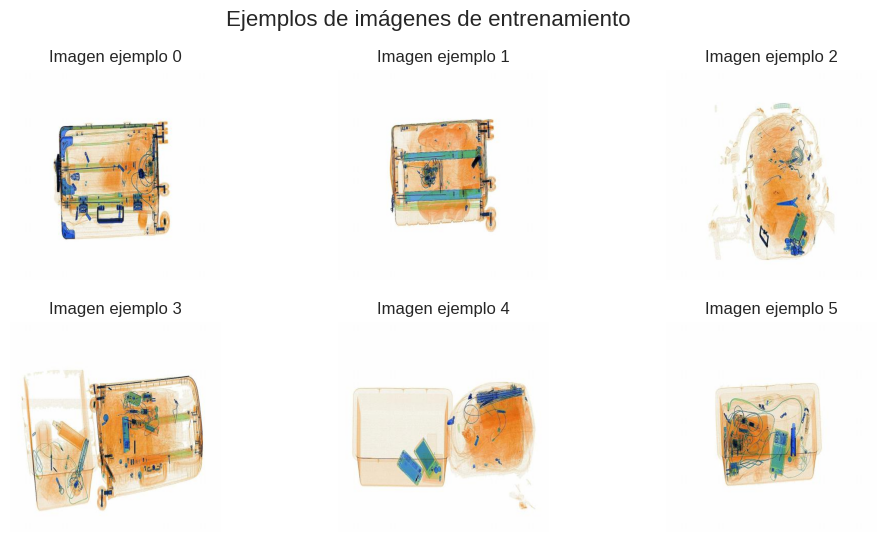


Total de imágenes (train): 6197
Total de etiquetas (train): 6181

Vista previa de las anotaciones:


In [ ]:
# ===========================
# Creacion del dataset de imagenes y analisis exporatorio
# ===========================
from google.colab import drive
drive.mount('/content/drive')

# ===========================
# Rutas base
# ===========================
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner")
SPLITS = ["train", "valid", "test"]
OBJECT_CLASSES = ['knife', 'firearm', 'pliers', 'scissors', 'wrench']

# ===========================
# Conteo de imágenes por split
# ===========================
print("Conteo de imágenes por conjunto:\n")
for s in SPLITS:
    imgs = list((BASE_DIR / s / "images").rglob("*.jpg")) + list((BASE_DIR / s / "images").rglob("*.png"))
    print(f"{s}: {len(imgs)} imágenes")

# ===========================
# Mostrar ejemplos aleatorios (train)
# ===========================
train_imgs = list((BASE_DIR / "train" / "images").rglob("*.jpg"))
sample_imgs = random.sample(train_imgs, min(6, len(train_imgs)))

plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_imgs):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Imagen ejemplo {i}') #
    plt.axis("off")
plt.suptitle("Ejemplos de imágenes de entrenamiento", fontsize=16)
plt.show()

# ===========================
# Lectura de etiquetas YOLO
# ===========================
IMAGES_DIR = BASE_DIR / "train" / "images"
LABELS_DIR = BASE_DIR / "train" / "labels"

images = sorted(os.listdir(IMAGES_DIR))
labels = sorted(os.listdir(LABELS_DIR))

print(f"\nTotal de imágenes (train): {len(images)}")
print(f"Total de etiquetas (train): {len(labels)}")

# Función para parsear las etiquetas YOLO (formato: class x_center y_center width height)
def parse_label(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            cls, x, y, w, h = map(float, parts)
            data.append([int(cls), x, y, w, h])
    return data

# ===========================
# Crear dataframe con todas las anotaciones
# ===========================
all_data = []
for lbl_file in labels:
    file_path = os.path.join(LABELS_DIR, lbl_file)
    img_name = lbl_file.replace(".txt", ".jpg")
    annotations = parse_label(file_path)
    for ann in annotations:
        cls, x, y, w, h = ann
        all_data.append([img_name, cls, x, y, w, h])

df = pd.DataFrame(all_data, columns=["imagen", "clase", "x", "y", "ancho", "alto"])
print("\nVista previa de las anotaciones:")

--------------------------------------------------------------------------------
Cargando y analizando etiquetas de clases...
--------------------------------------------------------------------------------


Procesando etiquetas en train:   0%|          | 0/6181 [00:00<?, ?it/s]

Procesando etiquetas en valid:   0%|          | 0/1766 [00:00<?, ?it/s]

Procesando etiquetas en test:   0%|          | 0/899 [00:00<?, ?it/s]


Resumen de Distribución de Clases:


,Clase,Cantidad
0,wrench,2025
1,firearm,1975
2,scissors,1948
3,knife,1857
4,pliers,1041


Analisis de la estructura del dataset


,Split,Images,Labels,Missing Labels,Size (MB),% of Data
0,train,6197,6181,16,99.653,70.054
1,valid,1766,1766,0,28.143,19.964
2,test,883,899,0,14.380,9.982
Total,TOTAL,8846,8846,16,142.177,100.000


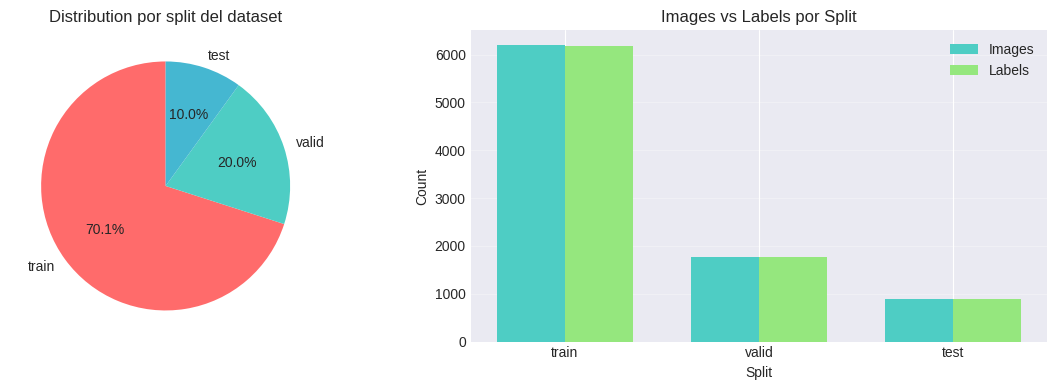

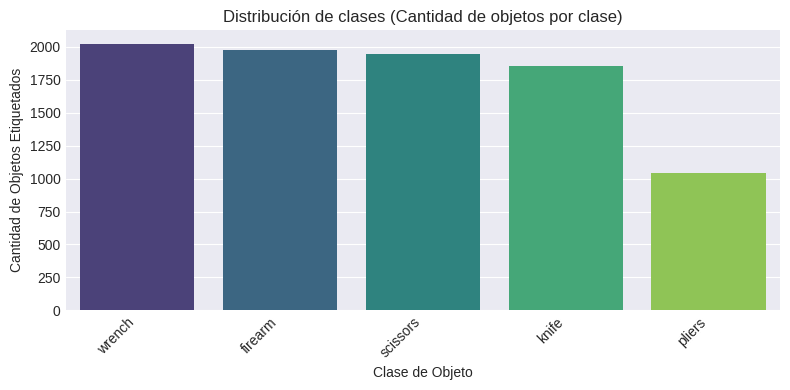

Analisis de calidad de las imagenes

Analizando 300 imagenes para train split...


Procesando train:   0%|          | 0/300 [00:00<?, ?it/s]


Analizando 300 imagenes para valid split...


Procesando valid:   0%|          | 0/300 [00:00<?, ?it/s]


Analizando 300 imagenes para test split...


Procesando test:   0%|          | 0/300 [00:00<?, ?it/s]


Resumen de estadistica de imagen:


,width,height,aspect_ratio,channels,file_size_kb,brightness,contrast,edge_density
count,900.000,900.000,900.000,900.000,900.000,900.000,900.000,900.000
mean,416.000,416.000,1.000,3.000,16.501,233.556,39.748,0.061
std,0.000,0.000,0.000,0.000,4.855,8.286,8.053,0.023
min,416.000,416.000,1.000,3.000,6.921,207.503,17.202,0.009
25%,416.000,416.000,1.000,3.000,12.274,228.135,33.710,0.042
50%,416.000,416.000,1.000,3.000,15.990,234.088,39.257,0.057
75%,416.000,416.000,1.000,3.000,20.271,240.500,45.660,0.078
max,416.000,416.000,1.000,3.000,30.733,249.688,64.051,0.133



Nro de dimensiones de imangen unicas encontradas: 1

Todas las dimensiones unicas son:
  416x416: 900 images


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from PIL import Image
import cv2
from tqdm.notebook import tqdm
from IPython.display import display

# --- Asunciones de Variables Globales (Asegúrate de que estén definidas) ---
# Ejemplo (usa tu ruta de Google Drive corregida):
# BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner")
# SPLITS = ["train", "valid", "test"]
# OBJECT_CLASSES = ['knife', 'firearm', 'pliers', 'scissors', 'wrench']
# -------------------------------------------------------------------------


def cargar_analizar_clases():
    """Carga los datos de las etiquetas YOLO (.txt) y calcula la distribución de clases."""
    all_label_data = []

    print("-" * 80)
    print("Cargando y analizando etiquetas de clases...")
    print("-" * 80)

    # 1. Recorrer todas las divisiones (splits)
    for split in SPLITS:
        labels_path = BASE_DIR / split / 'labels'
        if not labels_path.exists():
            continue

        label_files = list(labels_path.glob('*.txt'))

        # 2. Procesar cada archivo de etiqueta
        for label_path in tqdm(label_files, desc=f"Procesando etiquetas en {split}"):
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()

                # Cada línea es una detección: ClassID X_center Y_center W H
                for line in lines:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])

                        # 3. Guardar el resultado
                        all_label_data.append({
                            'split': split,
                            'class_id': class_id,
                            'clase': OBJECT_CLASSES[class_id] # Usar el nombre legible de la clase
                        })
            except Exception as e:
                print(f"Error leyendo {label_path.name}: {e}")

    # 4. Crear DataFrame para el análisis de clases
    df_labels = pd.DataFrame(all_label_data)

    # 5. Resumen de la distribución
    if not df_labels.empty:
        class_distribution = df_labels['clase'].value_counts().reset_index()
        class_distribution.columns = ['Clase', 'Cantidad']
        print("\nResumen de Distribución de Clases:")
        display(class_distribution)
    else:
        print("No se encontraron etiquetas para el análisis de clases.")

    return df_labels


def analisis_dataset_estructura(df_labels):
    """Analisis general de la estructura del dataset y visualización."""

    dataset_info = {
        'Split': [],
        'Images': [],
        'Labels': [],
        'Missing Labels': [],
        'Size (MB)': []
    }

    total_images = 0
    total_labels = 0
    total_size = 0

    print("=" * 80)
    print("Analisis de la estructura del dataset")
    print("=" * 80)

    for split in SPLITS:
        split_path = BASE_DIR / split

        if not split_path.exists():
            continue

        images_path = split_path / 'images'
        labels_path = split_path / 'labels'

        image_files = list(images_path.glob('*.jpg')) if images_path.exists() else []
        label_files = list(labels_path.glob('*.txt')) if labels_path.exists() else []

        # Check de labels faltantes
        image_names = {f.stem for f in image_files}
        label_names = {f.stem for f in label_files}
        missing_labels = image_names - label_names

        # Calulcar tamaño
        split_size = sum(f.stat().st_size for f in image_files) / (1024 * 1024) # MB

        dataset_info['Split'].append(split)
        dataset_info['Images'].append(len(image_files))
        dataset_info['Labels'].append(len(label_files))
        dataset_info['Missing Labels'].append(len(missing_labels))
        dataset_info['Size (MB)'].append(split_size)

        total_images += len(image_files)
        total_labels += len(label_files)
        total_size += split_size

    # Crear df
    df_structura = pd.DataFrame(dataset_info)

    # Agregar fila acumulado total
    df_structura.loc['Total'] = [
        'TOTAL',
        total_images,
        total_labels,
        df_structura['Missing Labels'].sum(), # Corregido: df_structura
        total_size
    ]

    # Columna porc.
    df_structura['% of Data'] = (df_structura['Images'] / total_images * 100)

    display(df_structura)

    # --- Visualización de Estructura ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Pie chart por splits
    split_data = df_structura[df_structura['Split'] != 'TOTAL']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    axes[0].pie(split_data['Images'], labels=split_data['Split'], autopct='%1.1f%%',
                colors=colors, startangle=90)
    axes[0].set_title('Distribution por split del dataset')

    # Bar chart para images vs labels
    x = np.arange(len(SPLITS))
    width = 0.35
    axes[1].bar(x - width/2, split_data['Images'], width, label='Images', color='#4ECDC4')
    axes[1].bar(x + width/2, split_data['Labels'], width, label='Labels', color='#95E77E')
    axes[1].set_xlabel('Split')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Images vs Labels por Split')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(SPLITS)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- Análisis de distribución de clases ---
    if not df_labels.empty:
        plt.figure(figsize=(8, 4))
        # Corregido: usando df_labels generado por la nueva función
        sns.countplot(x="clase", data=df_labels, palette="viridis", order=df_labels['clase'].value_counts().index)
        plt.title("Distribución de clases (Cantidad de objetos por clase)")
        plt.xlabel("Clase de Objeto")
        plt.ylabel("Cantidad de Objetos Etiquetados")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    return df_structura

# -----------------------------------------------------------------
# FUNCION PARA ANALIZAR PROPIEDADES DE IMAGENES (Sin cambios mayores)
# -----------------------------------------------------------------

def analizar_imagen_propiedades(sample_size=300):
    """Analizar propiedades de las imagenes incluyendo dimensiones, canales y calidad."""

    print("=" * 80)
    print("Analisis de calidad de las imagenes")
    print("=" * 80)

    all_stats = []

    # Ajustar el sample size si es mayor que el número total de imágenes
    all_image_files = []
    for split in SPLITS:
        images_path = BASE_DIR / split / 'images'
        if images_path.exists():
            all_image_files.extend(list(images_path.glob('*.jpg')))

    if len(all_image_files) < sample_size:
         sample_size = len(all_image_files)


    for split in SPLITS:
        images_path = BASE_DIR / split / 'images'
        if not images_path.exists():
            continue

        image_files = list(images_path.glob('*.jpg'))

        # Se trabaja con una muestra (ajustado por split)
        if len(image_files) > sample_size:
            files_to_sample = np.random.choice(image_files, sample_size, replace=False)
        else:
            files_to_sample = image_files

        print(f"\nAnalizando {len(files_to_sample)} imagenes para {split} split...")

        for img_path in tqdm(files_to_sample, desc=f"Procesando {split}"):
            try:
                # Abrir con PIL para stats basicas
                img_pil = Image.open(img_path)
                width, height = img_pil.size

                # Abrir con OpenCV para stats avanzadas
                img_cv = cv2.imread(str(img_path))

                if img_cv is not None:
                    # Obtener canales
                    channels = 1 if len(img_cv.shape) == 2 else img_cv.shape[2]

                    # Convertir a escala grises
                    # Asegurarse de que si ya es gris (channels=1) no se intenta convertir BGR2GRAY
                    if channels > 1:
                        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
                    else:
                        gray = img_cv

                    # Calcular metricas
                    brightness = np.mean(gray)
                    contrast = np.std(gray)

                    # Densidad de bordes usando Canny
                    edges = cv2.Canny(gray, 50, 150)
                    edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])

                    all_stats.append({
                        'split': split,
                        'filename': img_path.name,
                        'width': width,
                        'height': height,
                        'aspect_ratio': width / height,
                        'channels': channels,
                        'file_size_kb': img_path.stat().st_size / 1024,
                        'brightness': brightness,
                        'contrast': contrast,
                        'edge_density': edge_density
                    })

            except Exception as e:
                print(f"  Error al procesar {img_path.name}: {e}")

    # Crear df
    df_images = pd.DataFrame(all_stats)

    if df_images.empty:
        print("\nNo se pudieron procesar imágenes para el análisis de propiedades.")
        return pd.DataFrame()

    # Display estadisticas
    print("\nResumen de estadistica de imagen:")
    display(df_images.describe())

    # Check para dimensiones unicas
    unique_dims = df_images[['width', 'height']].drop_duplicates()
    print(f"\nNro de dimensiones de imangen unicas encontradas: {len(unique_dims)}")

    if len(unique_dims) <= 10:
        print("\nTodas las dimensiones unicas son:")
        for _, row in unique_dims.iterrows():
            count = len(df_images[(df_images['width'] == row['width']) &
                                 (df_images['height'] == row['height'])])
            print(f"  {int(row['width'])}x{int(row['height'])}: {count} images")
    else:
        print("\n Top 5 dimensiones mas comunes:")
        dim_counts = df_images.groupby(['width', 'height']).size().sort_values(ascending=False)
        for dims, count in dim_counts.head().items():
            print(f"  {int(dims[0])}x{int(dims[1])}: {count} images")

    return df_images


# -----------------------------------------------------------------
# EJECUCIÓN DEL ANÁLISIS
# -----------------------------------------------------------------

# Paso 1: Analizar y cargar datos de las etiquetas para la distribución de clases
df_labels = cargar_analizar_clases()

# Paso 2: Analizar la estructura del dataset, incluyendo la visualización de clases
df_estructura = analisis_dataset_estructura(df_labels)

# Paso 3: Analizar las propiedades de una muestra de imágenes
df_images = analizar_imagen_propiedades(sample_size=300)

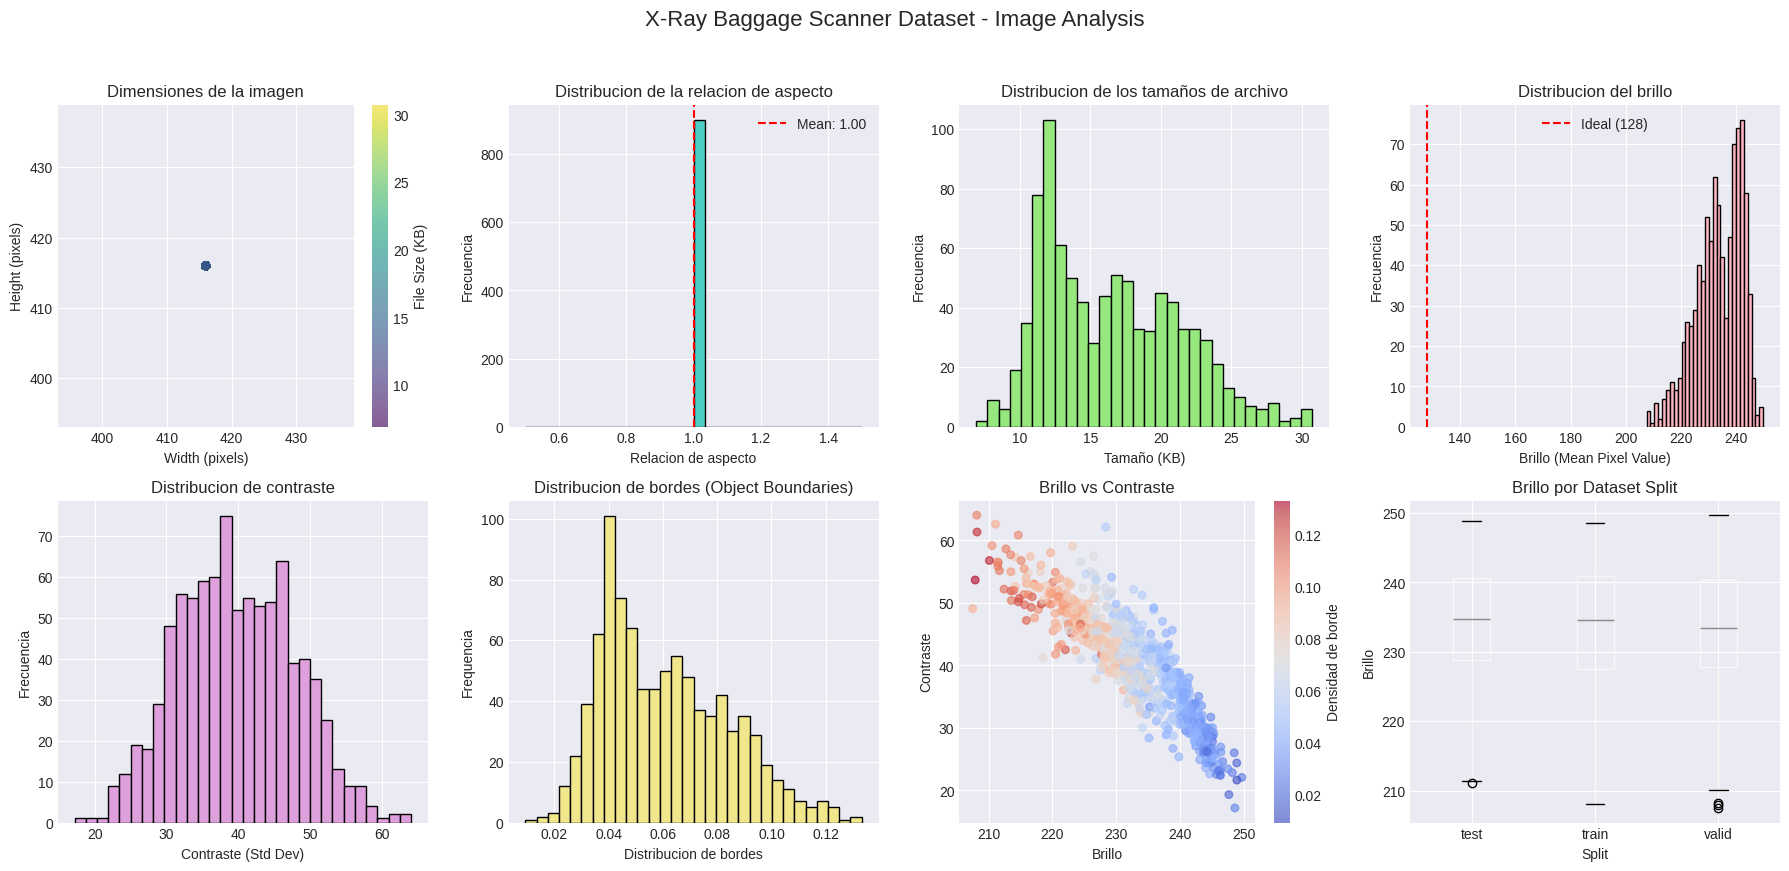

In [ ]:
# Visualization de las propiedades de la imagen
def visualizar_propiedades_imagen(df_images):
    """Visualizar propiedades de las imagenes"""

    fig = plt.figure(figsize=(18, 12))

    # scatter plot para las dimensiones
    ax1 = plt.subplot(3, 4, 1)
    scatter = ax1.scatter(df_images['width'], df_images['height'],
                         c=df_images['file_size_kb'], cmap='viridis',
                         alpha=0.6, s=30)
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Height (pixels)')
    ax1.set_title('Dimensiones de la imagen')
    plt.colorbar(scatter, ax=ax1, label='File Size (KB)')

    # 2. Distribucion de la relacion de aspecto
    ax2 = plt.subplot(3, 4, 2)
    ax2.hist(df_images['aspect_ratio'], bins=30, edgecolor='black', color='#4ECDC4')
    ax2.axvline(df_images['aspect_ratio'].mean(), color='red', linestyle='--',
                label=f'Mean: {df_images["aspect_ratio"].mean():.2f}')
    ax2.set_xlabel('Relacion de aspecto')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Distribucion de la relacion de aspecto')
    ax2.legend()

    # 3. Distribucion del tamaño
    ax3 = plt.subplot(3, 4, 3)
    ax3.hist(df_images['file_size_kb'], bins=30, edgecolor='black', color='#95E77E')
    ax3.set_xlabel('Tamaño (KB)')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribucion de los tamaños de archivo')

    # 4. Distribucion del brillo
    ax4 = plt.subplot(3, 4, 4)
    ax4.hist(df_images['brightness'], bins=30, edgecolor='black', color='#FFB6C1')
    ax4.axvline(128, color='red', linestyle='--', label='Ideal (128)')
    ax4.set_xlabel('Brillo (Mean Pixel Value)')
    ax4.set_ylabel('Frecuencia')
    ax4.set_title('Distribucion del brillo')
    ax4.legend()

    # 5. Contrast distribution
    ax5 = plt .subplot(3, 4, 5)
    ax5 .hist(df_images['contrast'], bins=30, edgecolor='black', color='#DDA0DD')
    ax5 .set_xlabel('Contraste (Std Dev)')
    ax5 .set_ylabel('Frecuencia')
    ax5 .set_title('Distribucion de contraste')

    # 6. Distribucion de la densidad de bordes
    ax6 = plt.subplot(3, 4, 6)
    ax6.hist(df_images['edge_density'], bins=30, edgecolor='black', color='#F0E68C')
    ax6.set_xlabel('Distribucion de bordes')
    ax6.set_ylabel('Frequencia')
    ax6.set_title('Distribucion de bordes (Object Boundaries)')

    # 7. Brillo vs Contraste scatter
    ax7 = plt.subplot(3, 4, 7)
    scatter2 = ax7 .scatter(df_images['brightness'], df_images['contrast'],
                          c=df_images['edge_density'], cmap='coolwarm',
                          alpha=0.6, s=30)
    ax7.set_xlabel('Brillo')
    ax7.set_ylabel('Contraste')
    ax7.set_title('Brillo vs Contraste')
    plt.colorbar(scatter2, ax=ax7, label='Densidad de borde')

    # 8. Box plots por split
    ax8 = plt.subplot(3, 4, 8)
    df_images.boxplot(column='brightness', by='split', ax=ax8)
    ax8.set_xlabel('Split')
    ax8.set_ylabel('Brillo')
    ax8.set_title('Brillo por Dataset Split')
    plt.sca(ax8)
    plt.xticks(rotation=0)



    plt.suptitle('X-Ray Baggage Scanner Dataset - Image Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

visualizar_propiedades_imagen(df_images)


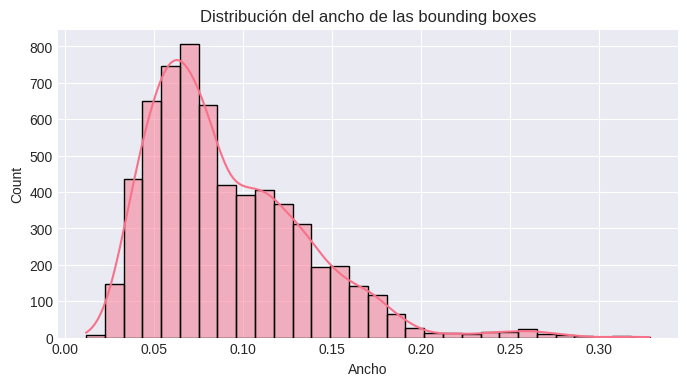

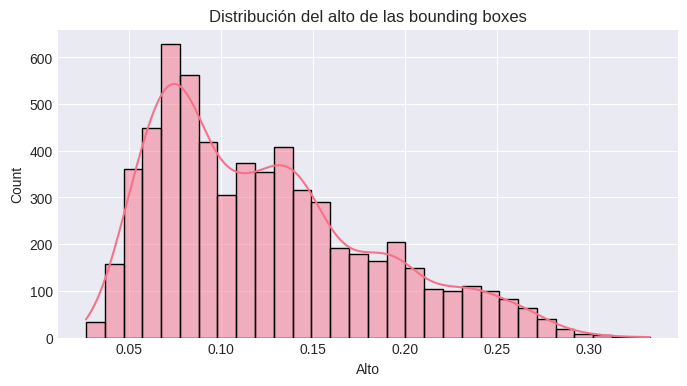

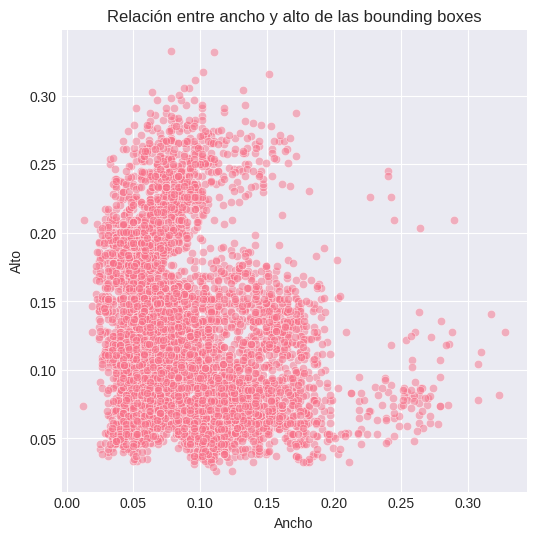


📈 Resumen estadístico de las cajas:
         ancho     alto
count 6181.000 6181.000
mean     0.091    0.124
std      0.044    0.059
min      0.012    0.026
25%      0.058    0.076
50%      0.081    0.112
75%      0.117    0.157
max      0.328    0.333
Analisis de labels (formato YOLO)

Analizando 6181 label del split train ...


Procesando train labels:   0%|          | 0/6181 [00:00<?, ?it/s]


Analizando 1766 label del split valid ...


Procesando valid labels:   0%|          | 0/1766 [00:00<?, ?it/s]


Analizando 899 label del split test ...


Procesando test labels:   0%|          | 0/899 [00:00<?, ?it/s]


  Distribucion de clases:
  wrench      :  2025 ( 22.9%)
  firearm     :  1975 ( 22.3%)
  scissors    :  1948 ( 22.0%)
  knife       :  1857 ( 21.0%)
  pliers      :  1041 ( 11.8%)

 Ratio desbalanceo de clases: 1.95

 Stats de objetos por imagen:
  train:
    Imagenes con objetos: 6181
    Imagenes sin objetos: 0
    Avg de objetos por imagen: 1.00
    Max objetos por imagen: 1
  valid:
    Imagenes con objetos: 1766
    Imagenes sin objetos: 0
    Avg de objetos por imagen: 1.00
    Max objetos por imagen: 1
  test:
    Imagenes con objetos: 899
    Imagenes sin objetos: 0
    Avg de objetos por imagen: 1.00
    Max objetos por imagen: 1

 Bounding Box Stats:
  Area - Min: 0.0009, Max: 0.0606, Mean: 0.0107
  Aspect Ratio - Min: 0.03, Max: 7.18, Mean: 0.98


In [ ]:
# 6. Analisis de Label  (Formato YOLO )
# ===========================
# Análisis de tamaños de bounding boxes
# ===========================
plt.figure(figsize=(8, 4))
sns.histplot(df["ancho"], bins=30, kde=True)
plt.title("Distribución del ancho de las bounding boxes")
plt.xlabel("Ancho")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["alto"], bins=30, kde=True)
plt.title("Distribución del alto de las bounding boxes")
plt.xlabel("Alto")
plt.show()

# ===========================
# Relación entre ancho y alto
# ===========================
plt.figure(figsize=(6, 6))
sns.scatterplot(x="ancho", y="alto", data=df, alpha=0.5)
plt.title("Relación entre ancho y alto de las bounding boxes")
plt.xlabel("Ancho")
plt.ylabel("Alto")
plt.show()

# ===========================
# Resumen estadístico
# ===========================
print("\n📈 Resumen estadístico de las cajas:")
print(df[["ancho", "alto"]].describe())



def analisis_yolo_labels():
    #Analizar labels formato YOLO

    print("=" * 80)
    print("Analisis de labels (formato YOLO)")
    print("=" * 80)

    all_annotations = []
    images_with_objects = defaultdict(int)
    objects_per_image = defaultdict(list)

    for split in SPLITS:
        labels_path = BASE_DIR / split / 'labels'
        if not labels_path.exists():
            continue

        label_files = list(labels_path.glob('*.txt'))
        print(f"\nAnalizando {len(label_files)} label del split {split} ...")

        for label_file in tqdm(label_files, desc=f"Procesando {split} labels"):
            image_name = label_file.stem

            with open(label_file, 'r') as f:
                lines = f.readlines()

            if len(lines) == 0:
                # Empty label file
                objects_per_image[split].append(0)
            else:
                images_with_objects[split] += 1
                objects_per_image[split].append(len(lines))

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])

                        class_name = OBJECT_CLASSES[class_id] if class_id < len(OBJECT_CLASSES) else f"Unknown_{class_id}"

                        all_annotations.append({
                            'split': split,
                            'image': image_name,
                            'class_id': class_id,
                            'class_name': class_name,
                            'x_center': x_center,
                            'y_center': y_center,
                            'bbox_width': width,
                            'bbox_height': height,
                            'bbox_area': width * height,
                            'bbox_aspect_ratio': width / height if height > 0 else 0
                        })

    # Crear df
    df_labels = pd.DataFrame(all_annotations)

    if len(df_labels) == 0:
        print(" empty file")
        return None

    # Distribucion de clases
    print("\n  Distribucion de clases:")
    class_counts = df_labels['class_name'].value_counts()
    for class_name, count in class_counts.items():
        percentage = (count / len(df_labels)) * 100
        print(f"  {class_name:12s}: {count:5d} ({percentage:5.1f}%)")

    # Desbalanceo de clases
    if len(class_counts) > 1:
        imbalance_ratio = class_counts.max() / class_counts.min()
        print(f"\n Ratio desbalanceo de clases: {imbalance_ratio:.2f}")
        if imbalance_ratio > 3:
            print("   Alto desbalanceo de clases, aplicar data augmentation es prioritario.")

    # Stats de objetos por imagen
    print("\n Stats de objetos por imagen:")
    for split in SPLITS:
        if split in objects_per_image:
            objs = objects_per_image[split]
            if objs:
                print(f"  {split}:")
                print(f"    Imagenes con objetos: {images_with_objects[split]}")
                print(f"    Imagenes sin objetos: {len(objs) - images_with_objects[split]}")
                print(f"    Avg de objetos por imagen: {np.mean(objs):.2f}")
                print(f"    Max objetos por imagen: {max(objs)}")

    # Stats Bounding box
    print("\n Bounding Box Stats:")
    print(f"  Area - Min: {df_labels['bbox_area'].min():.4f}, "
          f"Max: {df_labels['bbox_area'].max():.4f}, "
          f"Mean: {df_labels['bbox_area'].mean():.4f}")
    print(f"  Aspect Ratio - Min: {df_labels['bbox_aspect_ratio'].min():.2f}, "
          f"Max: {df_labels['bbox_aspect_ratio'].max():.2f}, "
          f"Mean: {df_labels['bbox_aspect_ratio'].mean():.2f}")

    return df_labels, objects_per_image

df_labels, objects_per_image = analisis_yolo_labels()

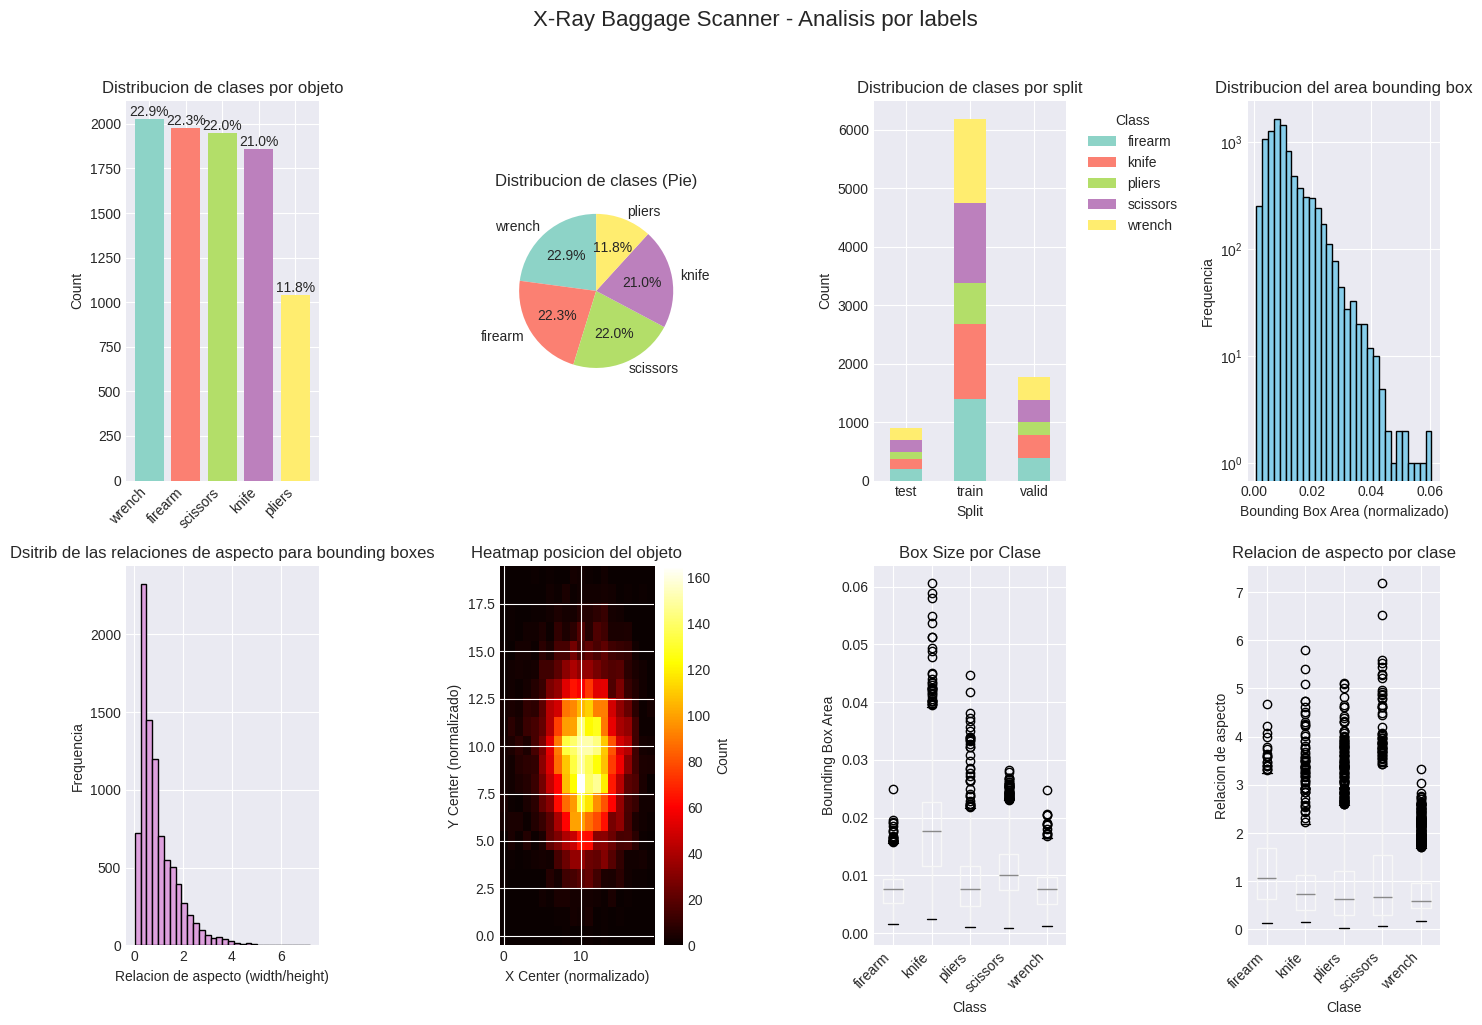

In [ ]:
# 7. Label Viz
def visualize_label_analysis(df_labels):
    #Analisis de label - visualizaciones

    fig = plt.figure(figsize=(14, 10))

    # 1. bar chart de distribucion de clases
    ax1 = plt.subplot(2, 4, 1)
    class_counts = df_labels['class_name'] .value_counts()
    colors = plt .cm .Set3(np .linspace(0, 1, len(class_counts)))
    bars = ax1 .bar(range(len(class_counts)), class_counts.values, color=colors)
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(class_counts.index, rotation=45, ha='right')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribucion de clases por objeto')

    # Agergar pct labels
    for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
        percentage = (count / len(df_labels)) * 100
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{percentage:.1f}%', ha='center', va='bottom')

    # 2. pie chart distribucion de clases
    ax2 = plt.subplot(2, 4, 2)
    ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax2.set_title('Distribucion de clases (Pie)')

    # 3. Distribucion de clases por split
    ax3 = plt.subplot(2, 4, 3)
    split_class_counts = df_labels.groupby(['split', 'class_name']).size().unstack(fill_value=0)
    split_class_counts.plot(kind='bar', stacked=True, ax=ax3, colormap='Set3')
    ax3.set_xlabel('Split')
    ax3.set_ylabel('Count')
    ax3.set_title('Distribucion de clases por split')
    ax3.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

    # 4. Distribucion del area de bounding box
    ax4 = plt.subplot(2, 4, 4)
    ax4.hist(df_labels['bbox_area'], bins=30, edgecolor='black', color='#87CEEB')
    ax4.set_xlabel('Bounding Box Area (normalizado)')
    ax4.set_ylabel('Frequencia')
    ax4.set_title('Distribucion del area bounding box')
    ax4.set_yscale('log')

    # 5. Ratio bounding box
    ax5 = plt.subplot(2, 4, 5)
    ax5.hist(df_labels['bbox_aspect_ratio'], bins=30, edgecolor='black', color='#DDA0DD')
    ax5.set_xlabel('Relacion de aspecto (width/height)')
    ax5.set_ylabel('Frequencia')
    ax5.set_title('Dsitrib de las relaciones de aspecto para bounding boxes')

    # 6. heatmap posicion del objeto
    ax6 = plt.subplot(2, 4, 6)
    heatmap, xedges, yedges = np.histogram2d(df_labels['x_center'],
                                             df_labels['y_center'], bins=20)
    im = ax6.imshow(heatmap.T, origin='lower', cmap='hot', aspect='auto')
    ax6.set_xlabel('X Center (normalizado)')
    ax6.set_ylabel('Y Center (normalizado)')
    ax6.set_title('Heatmap posicion del objeto')
    plt.colorbar(im, ax=ax6, label='Count')

    # 7. Box size por class
    ax7 = plt.subplot(2, 4, 7)
    df_labels.boxplot(column='bbox_area', by='class_name', ax=ax7)
    ax7.set_xlabel('Class')
    ax7.set_ylabel('Bounding Box Area')
    ax7.set_title('Box Size por Clase')
    plt.sca(ax7)
    plt.xticks(rotation=45, ha='right')

    # 8. Relacion de aspecto por clase
    ax8 = plt.subplot(2, 4, 8)
    df_labels.boxplot(column='bbox_aspect_ratio', by='class_name', ax=ax8)
    ax8.set_xlabel('Clase')
    ax8.set_ylabel('Relacion de aspecto')
    ax8.set_title('Relacion de aspecto por clase')
    plt.sca(ax8)
    plt.xticks(rotation=45, ha='right')

    plt.suptitle('X-Ray Baggage Scanner - Analisis por labels', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_label_analysis(df_labels)

## Ejemplo de como se va a hacer data augmentation:

Imágenes en train: 6197
Usando imagen de ejemplo: /content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner/train/images/025033_jpg.rf.6116952b0e9dd9259e3007383fa2b278.jpg


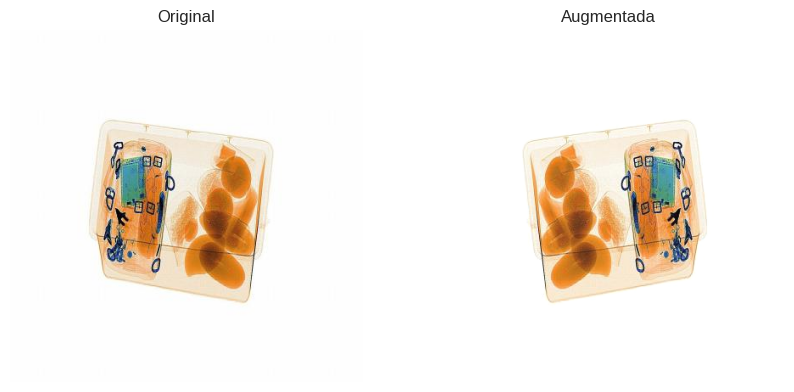

In [ ]:
# Data augmentation + manejo de errores
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Buscar imágenes en train/valid/test (si no existe sample_imgs)
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner')

train_images = list((DATA_DIR / "train" / "images").rglob("*.jpg")) + list((DATA_DIR / "train" / "images").rglob("*.png"))

print("Imágenes en train:", len(train_images))
if len(train_images) == 0:
    # fallback: buscar en todo el dataset
    all_imgs = list(DATA_DIR.rglob("*.jpg")) + list(DATA_DIR.rglob("*.png"))
    print("Imágenes totales encontradas (fallback):", len(all_imgs))
    if len(all_imgs) == 0:
        raise RuntimeError("No se encontraron imágenes en el dataset. Revisá DATA_DIR.")
    sample_img_path = str(all_imgs[0])
else:
    sample_img_path = str(random.choice(train_images))

print("Usando imagen de ejemplo:", sample_img_path)

# Defino augmentaciones válidas (sin parámetros inválidos)
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.03, scale=(0.92, 1.08), rotate=10, p=0.6),  # reemplaza ShiftScaleRotate
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
    A.Blur(blur_limit=3, p=0.2),
    A.CoarseDropout(p=0.2),  # simple, sin params que provoquen warning
])

# Leer imagen (cv2 devuelve BGR)
img = cv2.imread(sample_img_path)
if img is None:
    raise RuntimeError(f"No se pudo leer la imagen: {sample_img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Aplicar augment y mostrar
augmented = aug(image=img)['image']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Augmentada")
plt.imshow(augmented)
plt.axis("off")
plt.show()